# Solar components

* File name: solar_components.ipynb
* Last edited: 2020-06-30
* Created by: Stefan Bruche (TU Berlin)

<div class="alert alert-info">

**Note:** 
    
The solar classes require the availability of the Python module *pvlib*. The module is not provided with the standard installation of *aristopy*. If you want to use the solar classes, consider installing the module in your current environment, e.g. via:
    
```python
>> pip install pvlib 
```
    
For further information and an installation guide, users are referred to the [pvlib documentation](https://pvlib-python.readthedocs.io/en/stable/).

</div>

```python
import pandas as pd
import aristopy as ar

# Get data from csv-file
data = pd.read_csv('testdata.csv', sep=';', decimal='.', index_col=[0])

# Convert index to type DateTimeIndex and add required information about the time zone.
data.index = pd.to_datetime(
    data.index, format="%d.%m.%Y %H:%M").tz_localize(tz='UTC')

# Create a SolarData class instance with global (GHI) and diffuse (DHI)
# horizontal irradiation data for the location Potsdam/Germany.
solar = ar.SolarData(ghi=data['GHI [W/m2]'], dhi=data['DHI [W/m2]'],
                     latitude=52.3822, longitude=13.0622, altitude=81)


# Photovoltaic
# ------------
# Calculate the direct normal irradiation (DNI) from GHI, DHI and the solar positions
df_solar = solar.get_irradiance_dataframe()

# Append ambient temperature data (and wind speed if available)
df_solar['temp_air'] = data['T_amb [C]']

# Create a PV System (consisting of a module and an inverter).
pv_system = ar.PVSystem(module='Canadian_Solar_Inc__CS6X_300P',
                        inverter='Canadian_Solar_Inc___CSI_60KTL_CT__480V_')

# Calculate the feed-in of the PV system for specified conditions at a site 
# (irradiation, temperature, collector tilt and azimuth).
pv_feed_in = pv_system.get_feedin(
    weather=df_solar, location=solar.location,
    surface_tilt=30, surface_azimuth=180,  # South
    modules_per_string=20, strings_per_inverter=10, scaling='peak_power')  # [W/Wp]


# Solar thermal collector
# -----------------------
# Calculate the irradiance components on the solar-thermal collector array.
poa = solar.get_plane_of_array_irradiance(surface_tilt=45, surface_azimuth=180)

# Set up a solar collector array (type: evacuated tube collectors).
solar_collector_data = ar.SolarThermalCollector(
    optical_efficiency=0.80, thermal_loss_parameter_1=1.1,
    thermal_loss_parameter_2=0.008, irradiance_data=poa['poa_global'],
    t_ambient=data['T_amb [C]'], t_collector_in=60, t_collector_out=90)

# Calculate heat output of the solar-thermal collector
solar_heat = solar_collector_data.get_collector_heat_output()


# Solar components in the model
# -----------------------------
# Create energy system instance
es = ar.EnergySystem()

# Add a photovoltaic component (electricity source)
pv = ar.Source(
    ensys=es, name='pv', outlet=ar.Flow('Elec', 'elec_sink'),
    time_series_data=ar.Series('pv_feed_in', pv_feed_in),  # [MW/MWp]
    capacity=100, capex_per_capacity=700e3, opex_per_capacity=0.025*700e3,  # [MWp]
    user_expressions='Elec == CAP * pv_feed_in')

# Add a Solar-thermal collector component (heat source)
solar_collector = ar.Source(
    ensys=es, name='solar_collector', outlet=ar.Flow('Heat', 'heat_sink'),
    basic_variable='Area', additional_vars=ar.Var('Area', has_time_set=False),
    time_series_data=ar.Series('collector_feedin', solar_heat / 1e6),  # [MW/m²]
    user_expressions='Heat == collector_feedin * Area',
    capacity=1e5, capex_per_capacity=300, opex_per_capacity=300*0.01)  # [m²], [EUR/m²]

# Add sinks for electricity and heat
elec_sink = ar.Sink(ensys=es, name='elec_sink', inlet=ar.Flow('Elec'))
heat_sink = ar.Sink(ensys=es, name='heat_sink', inlet=ar.Flow('Heat'))

# Run the optimization
es.optimize()
```

### SolarData class

Read the input data from a csv-file for one year in hourly resolution (8760 time steps) with pandas.

In [1]:
# Import the required packages (jupyter magic only required for jupyter notebooks)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import aristopy as ar

# Get data from csv-file
data = pd.read_csv('testdata.csv', sep=';', decimal='.', index_col=[0])

The index of the solar data needs be of type DateTimeIndex and must contain information about the time zone. The Data from the reference "Deutscher Wetterdienst" ([DWD](https://opendata.dwd.de/climate_environment/CDC/)) is provided with a UTC timestamp. The same is true for the Photovoltaic Geographical Information System ([PVGIS](http://re.jrc.ec.europa.eu/pvgis/)) data of the JRC. So, we convert the index to a datetime and localize it to the UTC time zone. Alternatively, we could use the pandas method ```date_range``` to create a new index with time zone information included.

In [2]:
data.index = pd.to_datetime(
    data.index, format="%d.%m.%Y %H:%M").tz_localize(tz='UTC')

In [3]:
# print the time zone of the data index
data.index.tz

<UTC>

In [4]:
# print first rows
data.head(3)

,T_amb [C],DHI [W/m2],GHI [W/m2]
2018-01-01 00:00:00+00:00,11.3,0.0,0.0
2018-01-01 01:00:00+00:00,10.9,0.0,0.0
2018-01-01 02:00:00+00:00,11.1,0.0,0.0


A SolarData class instance is created with provided specifications for the location and irradiance data. The global (GHI) and diffuse (DHI) horizontal irradiation time series are required input arguments. The direct normal (beam) irradiation (DNI) can also be specified or is internally calculated based on GHI, DHI, and solar positions. The selected location is Potsdam/Germany. 
Later, the SolarData instance is used to calculate and return values for all irradiance time series ```get_irradiance_dataframe```, and the plane of array irradiance (POA) ```get_plane_of_array_irradiance```.

In [5]:
solar = ar.SolarData(ghi=data['GHI [W/m2]'], dhi=data['DHI [W/m2]'],
                     latitude=52.3822, longitude=13.0622, altitude=81)

### PVSystem class

First, we calculate the direct normal irradiation (DNI) from GHI, DHI, and solar positions of the respective location, and return the data in a pandas DataFrame. 

In [6]:
df_solar = solar.get_irradiance_dataframe()

If available, ambient temperature and wind speed data can be appended to the DataFrame. In this case, *pvlib* requires the column names: 'temp_air' and 'wind_speed'. This step is optional. Default values 20°C and 0 m/s are used, if no values are provided.

In [7]:
df_solar['temp_air'] = data['T_amb [C]']

In [8]:
# Print data of the first day 
df_solar.iloc[7:17]

,ghi,dhi,dni,temp_air
2018-01-01 07:00:00+00:00,0.000000,0.000000,-0.000000,8.7
2018-01-01 08:00:00+00:00,25.000000,22.222222,38.988546,7.8
2018-01-01 09:00:00+00:00,88.888889,58.333333,185.767900,7.7
2018-01-01 10:00:00+00:00,147.222222,80.555556,293.940748,8.0
2018-01-01 11:00:00+00:00,205.555556,72.222222,526.992007,8.4
2018-01-01 12:00:00+00:00,180.555556,97.222222,345.532381,9.1
2018-01-01 13:00:00+00:00,66.666667,61.111111,28.910901,8.6
2018-01-01 14:00:00+00:00,58.333333,44.444444,126.548503,7.9
2018-01-01 15:00:00+00:00,22.222222,19.444444,0.000000,7.3
2018-01-01 16:00:00+00:00,0.000000,0.000000,-0.000000,7.5


The next step is to create an instance of class PVSystem by selecting a type module and inverter from the pvlib's database. The full database currently consists of more than 20,000 modules and 3,000 inverters. To see the database you can either go through the CSV-files in the "data" directory of your pvlib installation, or use the method ```retrieve_sam```.

In [9]:
import pvlib

pvlib.pvsystem.retrieve_sam(name='cecmod')  # for inverters: name='cecinverter' 

,A10Green_Technology_A10J_S72_175,A10Green_Technology_A10J_S72_180,A10Green_Technology_A10J_S72_185,A10Green_Technology_A10J_M60_220,A10Green_Technology_A10J_M60_225,A10Green_Technology_A10J_M60_230,A10Green_Technology_A10J_M60_235,A10Green_Technology_A10J_M60_240,A2Peak_Power_POWER_ON_P220_6x10,Aavid_Solar_ASMS_165P,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
Technology,Mono-c-Si,Mono-c-Si,Mono-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,...,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si
Bifacial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
STC,175.091,179.928,184.702,219.876,224.986,230.129,235.008,240.538,219.978,164.85,...,275.014,280.329,285.326,290.036,295.066,300.003,305.056,310.144,315.094,320.42
PTC,151.2,155.7,160.2,189.1,193.5,204.1,208.7,213.3,195,146.3,...,248,252.6,257.3,261.9,266.5,271.2,275.8,280.5,285.1,289.8
A_c,1.3,1.3,1.3,1.624,1.624,1.624,1.624,1.624,1.633,1.301,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
Length,1.576,1.576,1.576,1.632,1.632,1.632,1.632,1.632,1.633,1.575,...,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95
Width,0.825,0.825,0.825,0.995,0.995,0.995,0.995,0.995,1,0.826,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
N_s,72,72,72,60,60,60,60,60,60,72,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,5.17,5.31,5.43,7.95,8.04,8.1,8.23,8.32,7.98,5.25,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,43.99,44.06,44.14,36.06,36.24,36.42,36.72,36.84,36.72,43.5,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6


In this example modules and inverter from the manufacturer Canadian Solar are applied. The modules (CS6X-P) use multi-c-Si technololgy and have a nominal power of 300 Wp (STC) and an efficiency of 15.6%. 200 modules are connected to a central inverter that has a nominal AC power of 60 kW.

In [10]:
pv_system = ar.PVSystem(module='Canadian_Solar_Inc__CS6X_300P',
                        inverter='Canadian_Solar_Inc___CSI_60KTL_CT__480V_')

To get the PV plant's electrical power output, we need to provide the irradiance data determined above and the specifications for the orientation of the modules (tilt and azimuth). An azimuth value of 180 represents a surface facing south, a tilt of 0 implies a horizontal module alignment. Furthermore, the electrical output is scaled to its peak power [W/Wp].

In [11]:
pv_feed_in = pv_system.get_feedin(
    weather=df_solar, location=solar.location,
    surface_tilt=30, surface_azimuth=180,  # South
    modules_per_string=20, strings_per_inverter=10, scaling='peak_power')  # [W/Wp]

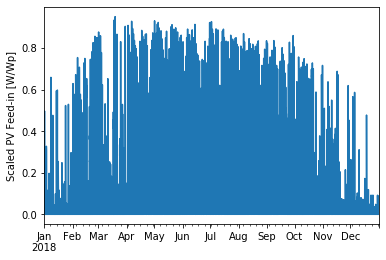

In [12]:
# Plot the PV feed-in (scaled to peak power)
pv_feed_in.plot()
plt.ylabel('Scaled PV Feed-in [W/Wp]')
plt.show()

### SolarThermalCollector class

The solar-thermal collector requires data for the plane of array irradiance (POA). The POA combines the direct normal (DNI) irradiance with sky diffuse and ground-reflected irradiance components and is returned as an OrderedDict or DataFrame via method ```get_plane_of_array_irradiance```. The method needs information about the array's orientation (tilt and azimuth) as input arguments. Additional keyword arguments (e.g., "albedo") can be specified via kwargs. 

In [13]:
poa = solar.get_plane_of_array_irradiance(
    surface_tilt=45, surface_azimuth=180)

In [14]:
# Print the components of POA data 
poa.iloc[7:17]

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2018-01-01 07:00:00+00:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2018-01-01 08:00:00+00:00,41.916672,22.033527,19.883144,18.967853,0.915291
2018-01-01 09:00:00+00:00,186.436000,133.391016,53.044984,49.790614,3.254369
2018-01-01 10:00:00+00:00,315.071214,240.922697,74.148516,68.758468,5.390049
2018-01-01 11:00:00+00:00,523.571366,454.400115,69.171251,61.645523,7.525729
2018-01-01 12:00:00+00:00,380.848212,291.253417,89.594795,82.984357,6.610437
2018-01-01 13:00:00+00:00,76.660323,22.057950,54.602373,52.161596,2.440777
2018-01-01 14:00:00+00:00,119.564815,79.493429,40.071386,37.935706,2.135680
2018-01-01 15:00:00+00:00,17.410464,0.000000,17.410464,16.596871,0.813592
2018-01-01 16:00:00+00:00,0.000000,-0.000000,0.000000,0.000000,0.000000


Set up a solar collector array (type: evacuated tube collectors).
The internal procedure to calculate the collector thermal energy output is adopted from reference: <br>
*V.Quaschning, 'Regenerative Energiesysteme', 10th edition, Hanser, 2019, p.131ff.* <br>
Characteristic values for the parametrization of different collector types are also indicated in this reference.

In [15]:
solar_collector_data = ar.SolarThermalCollector(
    optical_efficiency=0.80, thermal_loss_parameter_1=1.1,
    thermal_loss_parameter_2=0.008, irradiance_data=poa['poa_global'],
    t_ambient=data['T_amb [C]'], t_collector_in=60, t_collector_out=90)

The thermal energy output of the solar collector is calculated and returned by method ```get_collector_heat_output```.

In [16]:
solar_heat = solar_collector_data.get_collector_heat_output()

In [17]:
solar_heat[7:17]

2018-01-01 07:00:00+00:00      0.000000
2018-01-01 08:00:00+00:00      0.000000
2018-01-01 09:00:00+00:00     38.884480
2018-01-01 10:00:00+00:00    142.444971
2018-01-01 11:00:00+00:00    310.112613
2018-01-01 12:00:00+00:00    197.446090
2018-01-01 13:00:00+00:00      0.000000
2018-01-01 14:00:00+00:00      0.000000
2018-01-01 15:00:00+00:00      0.000000
2018-01-01 16:00:00+00:00      0.000000
dtype: float64

The data section above shows that despite present irradiation on the collector in the hours 1 pm to 3 pm, no useful thermal energy is released. That is explainable by the high share of heat losses at large temperature differences and a low total irradiance. The following figure shows that depending on the outside temperature, the collector efficiency can even drop to zero. Thus, no further thermal energy is extracted.

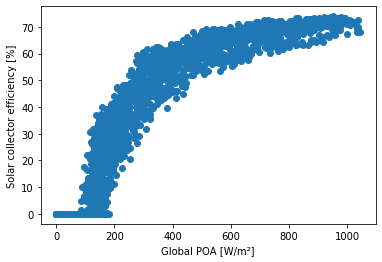

In [18]:
plt.scatter(poa['poa_global'], solar_collector_data.collector_efficiency*100)
plt.xlabel('Global POA [W/m²]'), plt.ylabel('Solar collector efficiency [%]')
plt.show()

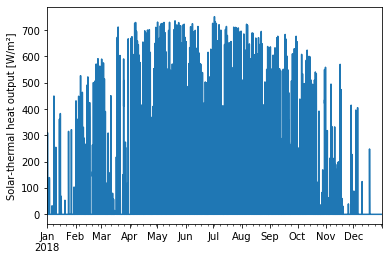

In [19]:
# Plot the specific solar-thermal heat output
solar_heat.plot()
plt.ylabel('Solar-thermal heat output [W/m²]')
plt.show()

### Simple solar model

The following simple model exemplarily shows how to use the generated feed-in time series of the PVSystem and the SolarThermalCollector classes in an *aristopy* model. The model could easily be extended, e.g., by adding a heat pump or a (seasonal) thermal storage system. 

In [20]:
# Create energy system instance
es = ar.EnergySystem()

The feed-in time series of the PV system can be introduced directly to the model with an electricity providing instance of the Source class. Since the applied time series is scaled to the peak power value, we need to multiply this relative value with the overall capacity of the PV plant in a user expression. 

In [21]:
# Add a photovoltaic component (electricity source)
pv = ar.Source(
    ensys=es, name='pv', outlet=ar.Flow('Elec', 'elec_sink'),
    time_series_data=ar.Series('pv_feed_in', pv_feed_in),  # [MW/MWp]
    capacity=100, capex_per_capacity=700e3, opex_per_capacity=0.025*700e3,  # [MWp]
    user_expressions='Elec == CAP * pv_feed_in')

The Source class is also used to impose the solar-thermal heat output. 
The available time-series provides area-specific data, so the delivered thermal energy is calculated as the product of the time series values and the collector area. The area is introduced as an additional variable without time dependency via the "additional_vars" keyword. Since also the costs of the plant are area-related [EUR/m²], the Area varibale is defined as the basic variable of the component (see [Component class API](component.rst)).

In [22]:
# Add a Solar-thermal collector component (heat source)
solar_collector = ar.Source(
    ensys=es, name='solar_collector', outlet=ar.Flow('Heat', 'heat_sink'),
    basic_variable='Area', additional_vars=ar.Var('Area', has_time_set=False),
    time_series_data=ar.Series('collector_feedin', solar_heat / 1e6),  # [MW/m²]
    user_expressions='Heat == collector_feedin * Area',
    capacity=1e5, capex_per_capacity=300, opex_per_capacity=300*0.01)  # [m²], [EUR/m²]

# Add sinks for electricity and heat
elec_sink = ar.Sink(ensys=es, name='elec_sink', inlet=ar.Flow('Elec'))
heat_sink = ar.Sink(ensys=es, name='heat_sink', inlet=ar.Flow('Heat'))

# Run the optimization
es.optimize(tee=False)

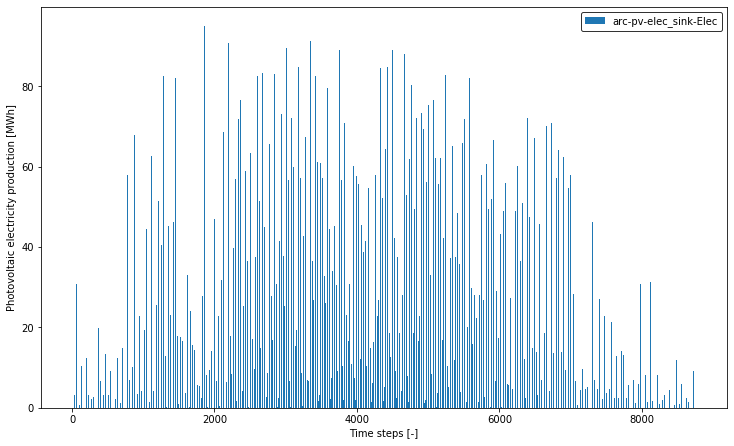

In [23]:
# Plot PV feed-in to electricity sink
plotter = ar.Plotter(json_file='results.json')
plotter.plot_operation('elec_sink', 'Elec', show_plot=True, 
                       ylabel='Photovoltaic electricity production [MWh]')

In [24]:
print(f'Capacity PV system:    {pv.block.CAP.value} MW')
print(f'Electricity PV system: {sum(pv.block.Elec.get_values().values())} MWh/a')

Capacity PV system:    100.0 MW
Electricity PV system: 133830.5074627531 MWh/a


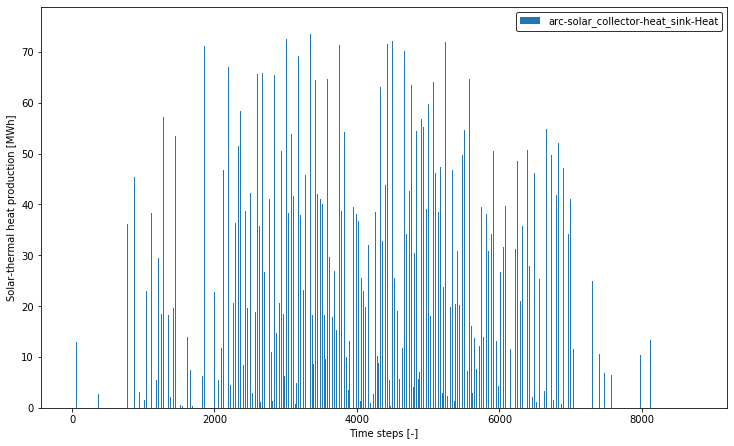

In [25]:
# Plot solar collector feed-in to heat sink
plotter.plot_operation('heat_sink', 'Heat', show_plot=True, 
                       ylabel='Solar-thermal heat production [MWh]')

In [26]:
print(f'Area solar collector:  {solar_collector.block.Area.value} m²')
print(f'Heat solar collector:  {sum(solar_collector.block.Heat.get_values().values())} MWh/a')

Area solar collector:  100000.0 m²
Heat solar collector:  78976.54196102788 MWh/a
